<a href="https://colab.research.google.com/github/clayedw/RET-2024/blob/main/a_bunch_of_power_spectra_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q condacolab

import condacolab

condacolab.install()

!conda install --no-pin pyccl

import pyccl as ccl

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



Redshift Distribution: The redshift distribution is defined and plotted.


Binning Class: The Binning class is defined to handle binning the redshift distribution into tomographic bins with equal number density.

Compute Equal Number Density Bins: The compute_equal_number_bounds method determines the bin edges that result in equal number densities.

Lens Bins: The lens_bins method computes the redshift distributions for each bin, normalizing them if specified.

Plotting: The redshift distributions for each bin are plotted to visualize the results.

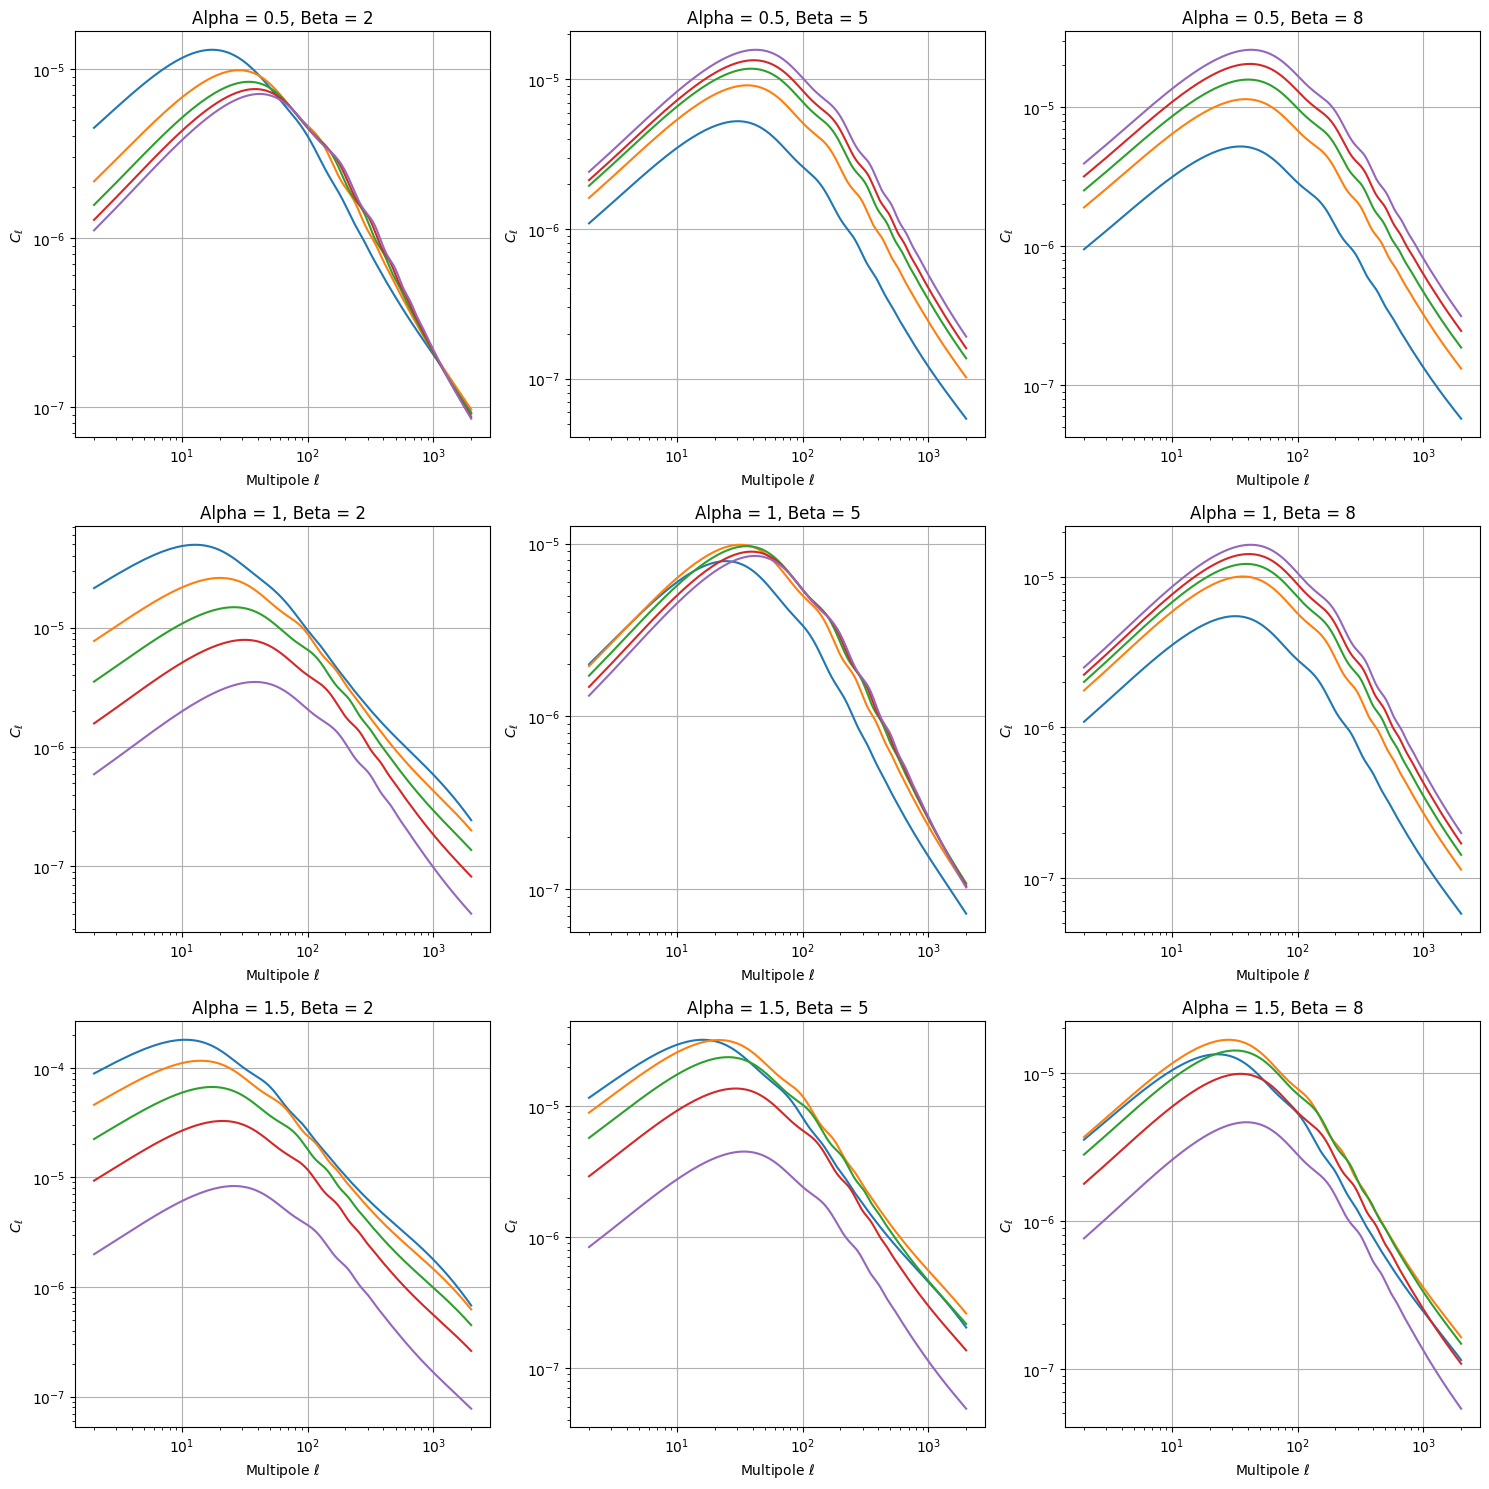

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy import integrate
import yaml
import pyccl as ccl

class SRDRedshiftDistributions:
    def __init__(self, redshift_range):
        self.redshift_range = redshift_range

    def smail_type_distribution(self, pivot_redshift, alpha, beta):
        redshift_distribution = [(z / pivot_redshift) ** beta * np.exp(-(z / pivot_redshift) ** alpha) for z in self.redshift_range]
        return np.array(redshift_distribution)

class Binning:
    def __init__(self, redshift_range, redshift_distribution, forecast_year):
        supported_forecast_years = {"1", "10"}
        if forecast_year in supported_forecast_years:
            self.forecast_year = forecast_year
        else:
            raise ValueError(f"forecast_year must be one of {supported_forecast_years}.")

        self.redshift_range = redshift_range
        self.redshift_distribution = redshift_distribution

        with open("lsst_desc_parameters.yaml", "r") as f:
            self.lsst_parameters = yaml.load(f, Loader=yaml.FullLoader)

        self.lens_params = self.lsst_parameters["lens_sample"][self.forecast_year]
        self.source_params = self.lsst_parameters["source_sample"][self.forecast_year]

    def true_redshift_distribution(self, upper_edge, lower_edge, variance, bias):
        scatter = variance * (1 + self.redshift_range)
        lower_limit = (upper_edge - self.redshift_range + bias) / np.sqrt(2) / scatter
        upper_limit = (lower_edge - self.redshift_range + bias) / np.sqrt(2) / scatter
        true_redshift_distribution = 0.5 * np.array(self.redshift_distribution) * (erf(upper_limit) - erf(lower_limit))
        return true_redshift_distribution

    def compute_equal_number_bounds(self, n_bins):
        cumulative_distribution = integrate.cumulative_trapezoid(self.redshift_distribution, self.redshift_range, initial=0)
        total_galaxies = cumulative_distribution[-1]
        bin_edges = []
        for i in range(1, n_bins):
            fraction = i / n_bins * total_galaxies
            bin_edge = np.interp(fraction, cumulative_distribution, self.redshift_range)
            bin_edges.append(bin_edge)
        return [self.redshift_range[0]] + bin_edges + [self.redshift_range[-1]]

    def lens_bins(self, normalised=True, save_file=True, file_format='npy'):
        bins = np.arange(self.lens_params["bin_start"],
                         self.lens_params["bin_stop"] + self.lens_params["bin_spacing"],
                         self.lens_params["bin_spacing"])

        lens_z_bias_list = np.repeat(self.lens_params["z_bias"], self.lens_params["n_tomo_bins"])
        lens_z_variance_list = np.repeat(self.lens_params["sigma_z"], self.lens_params["n_tomo_bins"])

        lens_redshift_distribution_dict = {}
        for index, (x1, x2) in enumerate(zip(bins[:-1], bins[1:])):
            z_bias = lens_z_bias_list[index]
            z_variance = lens_z_variance_list[index]
            lens_redshift_distribution_dict[index] = self.true_redshift_distribution(x1, x2, z_variance, z_bias)

        if normalised:
            for key in lens_redshift_distribution_dict.keys():
                norm_factor = np.sum(lens_redshift_distribution_dict[key])
                lens_redshift_distribution_dict[key] /= norm_factor

        combined_data = {'redshift_range': self.redshift_range, 'bins': lens_redshift_distribution_dict}

        if save_file:
            self.save_to_file(combined_data, "lens", file_format)

        return lens_redshift_distribution_dict

    def get_bin_centers(self, decimal_places=2, save_file=True):
        bin_centers = {"sources": [], "lenses": []}
        lens_bins = self.lens_bins(normalised=True, save_file=False)
        for index in range(self.lens_params["n_tomo_bins"]):
            bin_center = self.find_bin_center(lens_bins[index], self.redshift_range, decimal_places)
            bin_centers["lenses"].append(bin_center)
        if save_file:
            np.save(f'./srd_bin_centers_y_{self.forecast_year}.npy', bin_centers)
        return bin_centers

    def find_bin_center(self, bin_distribution, redshift_range, decimal_places=2):
        max_index = np.argmax(bin_distribution)
        return round(redshift_range[max_index], decimal_places)

    def save_to_file(self, data, name, file_format="npy"):
        if file_format == "npy":
            np.save(f"./srd_{name}_bins_year_{self.forecast_year}.npy", data)
        elif file_format == "csv":
            import pandas as pd
            dndz_df = pd.DataFrame(data)
            dndz_df.to_csv(f"./srd_{name}_bins_year_{self.forecast_year}.csv", index=False)

def plot_power_spectra(alpha_values, beta_values):
    cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)
    redshift_range = np.linspace(0.2, 1.2, 512)
    pivot_redshift = 0.26
    forecast_year = "1"
    n_bins = 5

    fig, axes = plt.subplots(len(alpha_values), len(beta_values), figsize=(15, 15))

    for i, alpha in enumerate(alpha_values):
        for j, beta in enumerate(beta_values):
            srd = SRDRedshiftDistributions(redshift_range)
            redshift_distribution = srd.smail_type_distribution(pivot_redshift, alpha, beta)
            binning = Binning(redshift_range, redshift_distribution, forecast_year)
            bin_edges = binning.compute_equal_number_bounds(n_bins)
            lens_bins = binning.lens_bins(normalised=True, save_file=False)

            tracers = []
            for b in range(n_bins):
                z_bin = redshift_range[(redshift_range >= bin_edges[b]) & (redshift_range < bin_edges[b + 1])]
                dNdz_bin = redshift_distribution[(redshift_range >= bin_edges[b]) & (redshift_range < bin_edges[b + 1])]
                bias_bin = np.ones_like(z_bin)
                tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_bin, dNdz_bin), bias=(z_bin, bias_bin))
                tracers.append(tracer)

            ell = np.arange(2, 2000)
            cls = [ccl.angular_cl(cosmo, tracer, tracer, ell) for tracer in tracers]

            for cl in cls:
                axes[i, j].plot(ell, cl)

            axes[i, j].set_xscale('log')
            axes[i, j].set_yscale('log')
            axes[i, j].set_xlabel('Multipole $\ell$')
            axes[i, j].set_ylabel('$C_\ell$')
            axes[i, j].set_title(f'Alpha = {alpha}, Beta = {beta}')
            axes[i, j].grid(True)

    plt.tight_layout()
    plt.show()

alpha_values = [0.5, 1, 1.5]
beta_values = [2, 5, 8]
plot_power_spectra(alpha_values, beta_values)
